# 付録B: 機械学習の解釈手法で線形回帰モデルを解釈する

In [1]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any  # 型ヒント用
from __future__ import annotations  # 型ヒント用

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib  # matplotlibの日本語表示対応

# 自作モジュール
sys.path.append("..")
from mli.visualize import get_visualization_setting

np.random.seed(42)
pd.options.display.float_format = "{:.2f}".format
sns.set(**get_visualization_setting())
warnings.simplefilter("ignore")  # warningsを非表示に

In [2]:
def generate_simulation_data(N=10000, J=50):
    """シミュレーションデータを生成する"""
    
    alpha = 1
    beta = np.random.uniform(0, 1, J)
    X = np.random.multivariate_normal(np.zeros(J), np.eye(J), N)
    epsilon = np.random.normal(0, 0.1, N)
    
    # 線形和で目的変数を作成
    y = alpha + X @ beta + epsilon

    return X, y, beta


# シミュレーションデータの生成
X, y, beta = generate_simulation_data()

In [3]:
from sklearn.linear_model import LinearRegression


# 線形回帰モデルの学習
lm = LinearRegression().fit(X, y)

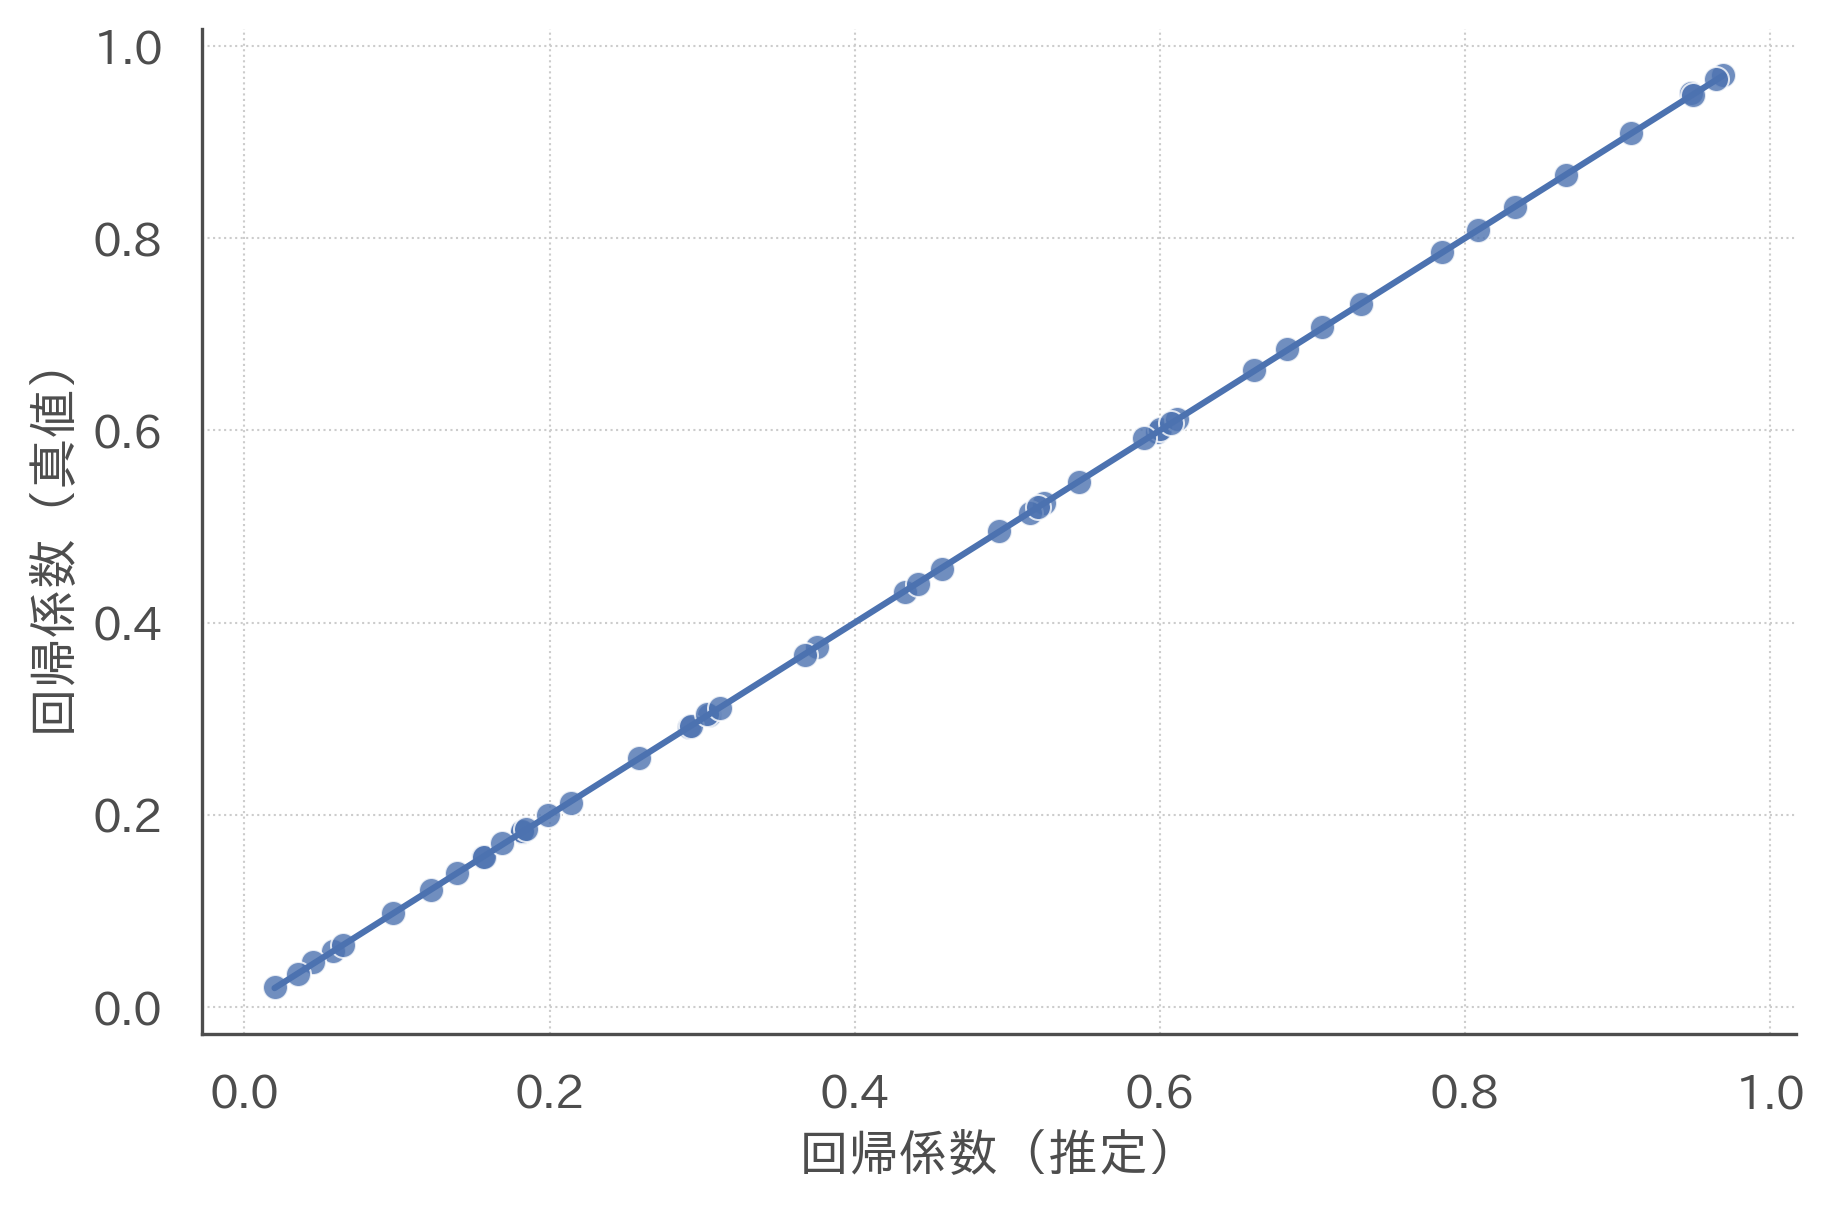

In [4]:
def plot_scatter(
    x, y, intercept=0, slope=1, xlabel=None, ylabel=None, title=None
):
    """散布図を作成"""

    # 散布図上にy = intercept + slope * xの直線を引くため
    xx = np.linspace(x.min(), x.max())
    yy = intercept + slope * xx

    fig, ax = plt.subplots()
    sns.lineplot(xx, yy, ax=ax)  # 直線
    sns.scatterplot(x, y, zorder=2, alpha=0.8, ax=ax)  # 散布図
    ax.set(xlabel=xlabel, ylabel=ylabel)
    fig.suptitle(title)

    fig.show()


# 可視化
# intercept=0, slope=1なので、直線はy=xが表示される
plot_scatter(lm.coef_, beta, xlabel="回帰係数（推定）", ylabel="回帰係数（真値）")

In [5]:
from sklearn.inspection import permutation_importance


# PFIを計算
pfi = permutation_importance(
    estimator=lm, X=X, y=y, scoring="neg_mean_squared_error", n_repeats=50
)["importances_mean"]

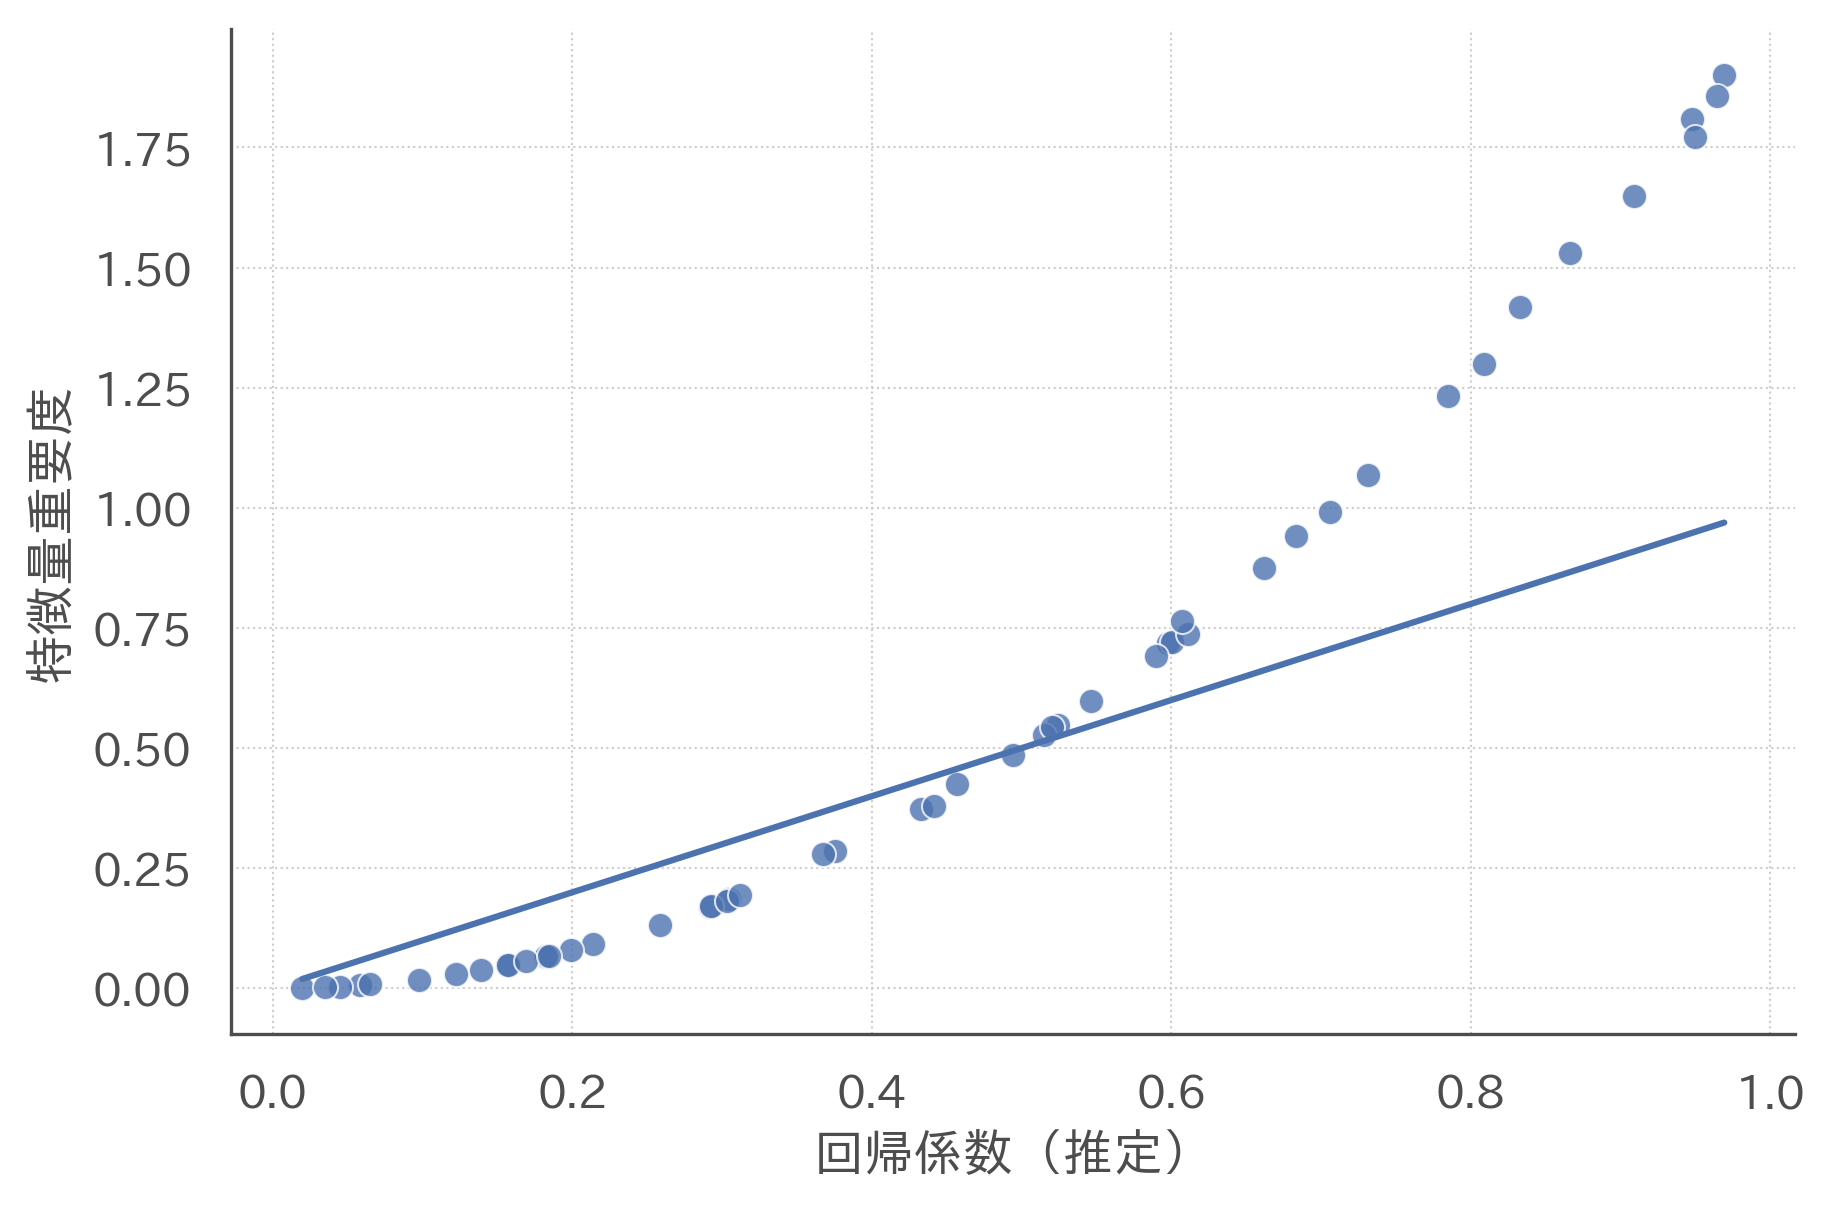

In [6]:
# 線形回帰モデルの回帰係数とPFIの関係を可視化
plot_scatter(lm.coef_, pfi, xlabel="回帰係数（推定）", ylabel="特徴量重要度")

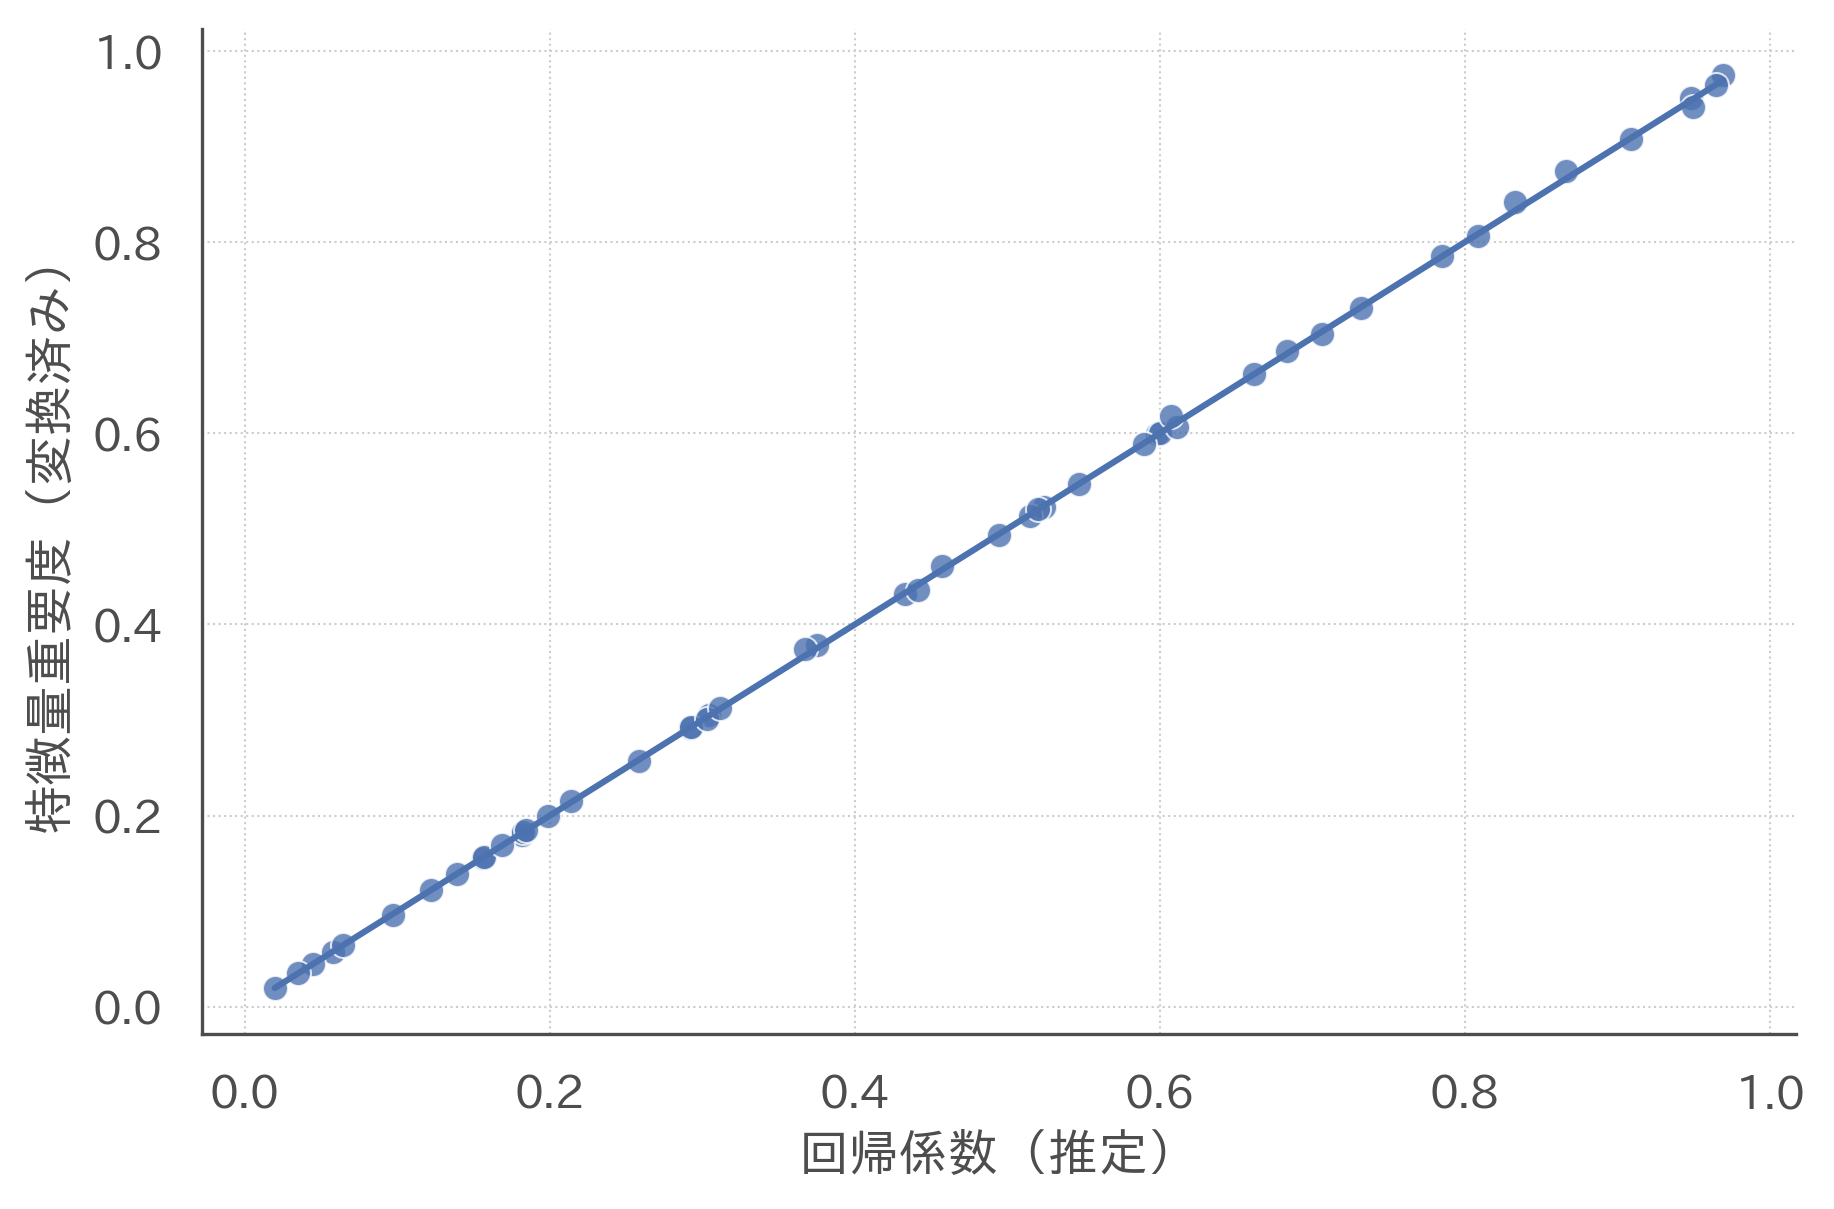

In [7]:
# 特徴量重要度を変換して可視化
plot_scatter(lm.coef_, np.sqrt(pfi / 2), xlabel="回帰係数（推定）", ylabel="特徴量重要度（変換済み）")

In [8]:
from sklearn.inspection import partial_dependence


# 特徴量X0に対するPDを計算
j = 0  # 特徴量のインデックス
pdp = partial_dependence(estimator=lm, X=X, features=[j], kind="average")

In [9]:
# 回帰係数を確認
print(f"特徴量X{j}の回帰係数：{lm.coef_[j]:.2f}")

特徴量X0の回帰係数：0.38


In [10]:
# 特徴量X0以外の要素を取り出し
X_wo_j = np.delete(X, [j], axis=1)
beta_wo_j = np.delete(lm.coef_, [j])

# 切片部分を計算
intercept_j = lm.intercept_ + X_wo_j.mean(axis=0) @ beta_wo_j

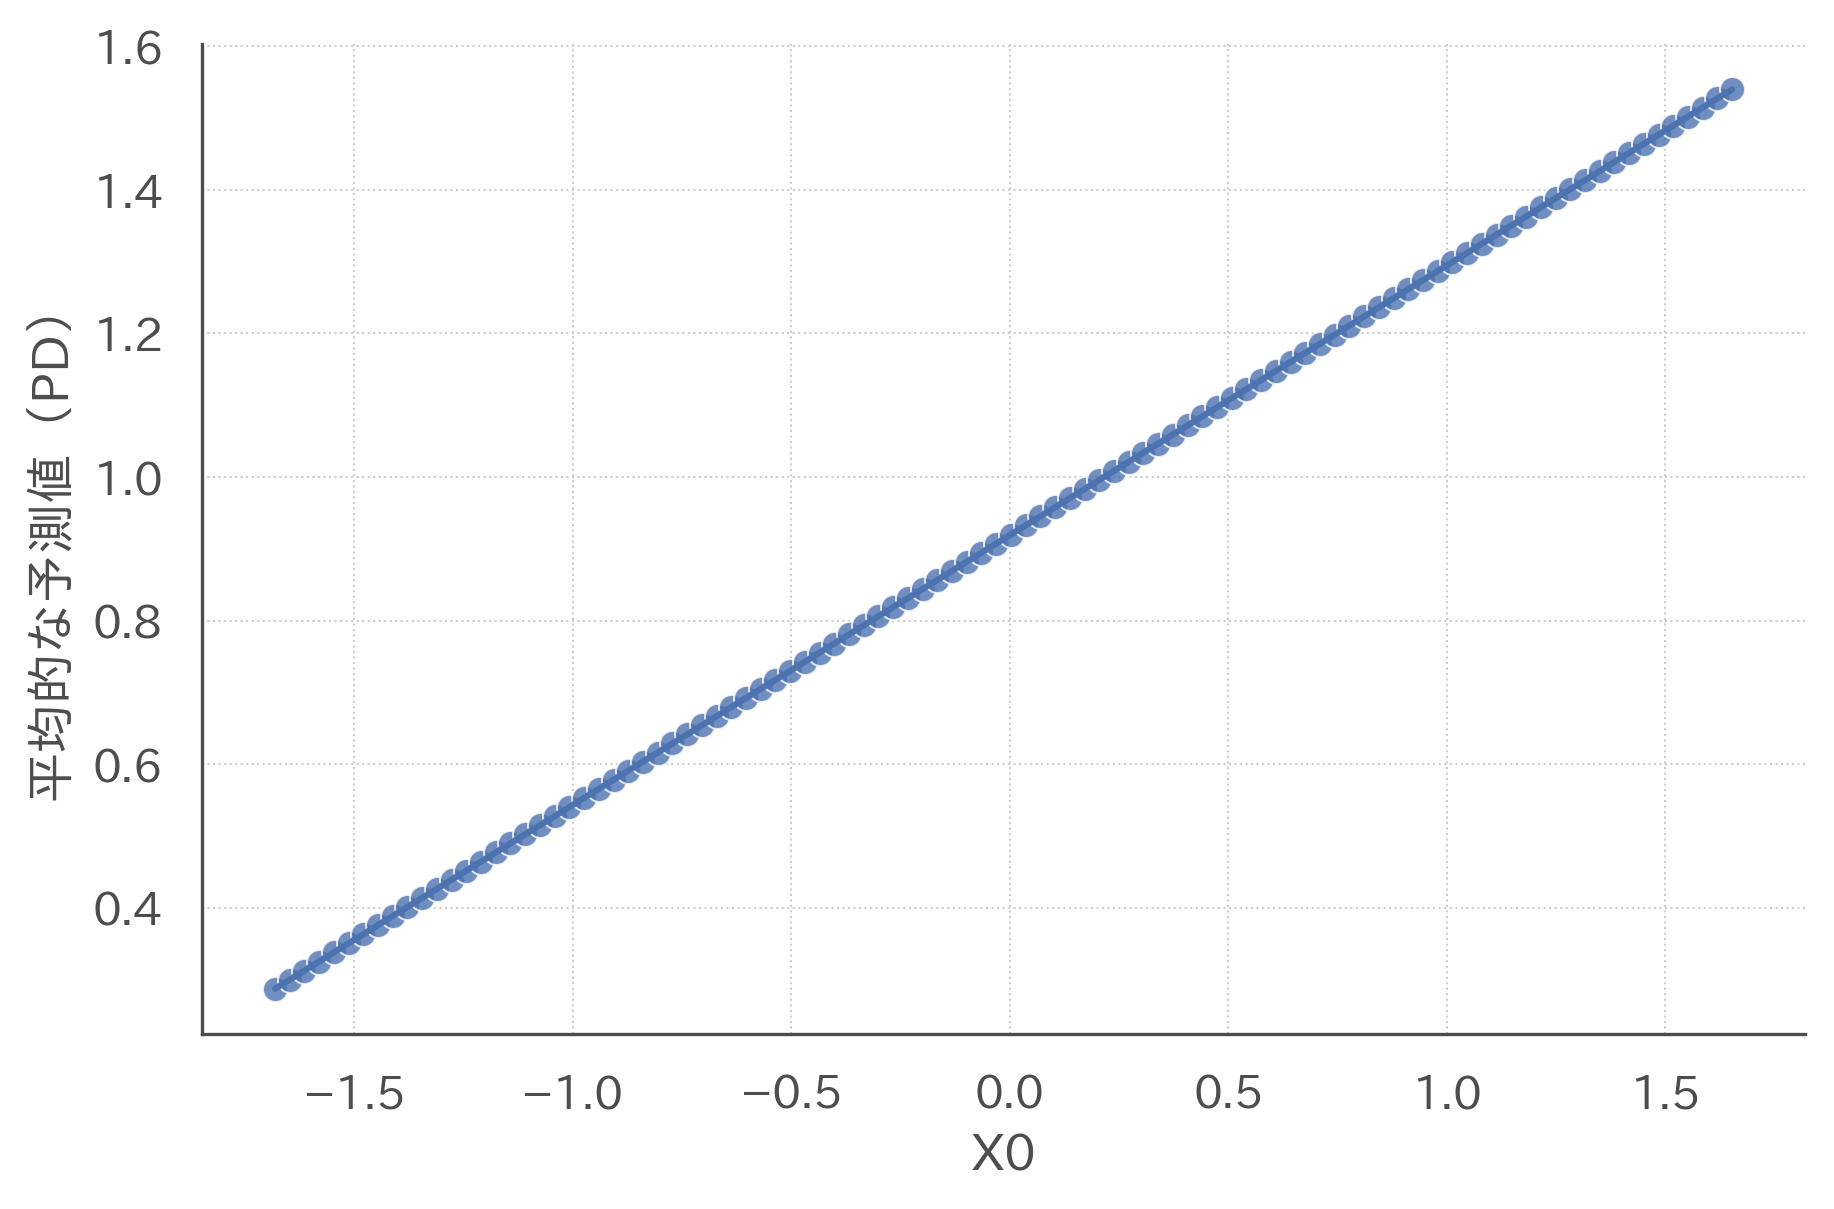

In [11]:
# PDを可視化
plot_scatter(
    pdp["values"][0],
    pdp["average"][0],
    intercept=intercept_j,  # 計算したPDの切片
    slope=lm.coef_[j],  # 傾き
    xlabel=f"X{j}",
    ylabel="平均的な予測値（PD）",
)

In [12]:
# インスタンス0の特徴量X0に対してICEを計算
i = 0  # インスタンスのインデックス
j = 0  # 特徴量のインデックス

ice = partial_dependence(estimator=lm, X=X, features=[j], kind="individual")

In [13]:
# 特徴量X0以外の要素を取り出し
X_wo_j = np.delete(X, [j], axis=1)
beta_wo_j = np.delete(lm.coef_, [j])

# 切片部分を計算
intercept_ij = lm.intercept_ + X_wo_j[i] @ beta_wo_j

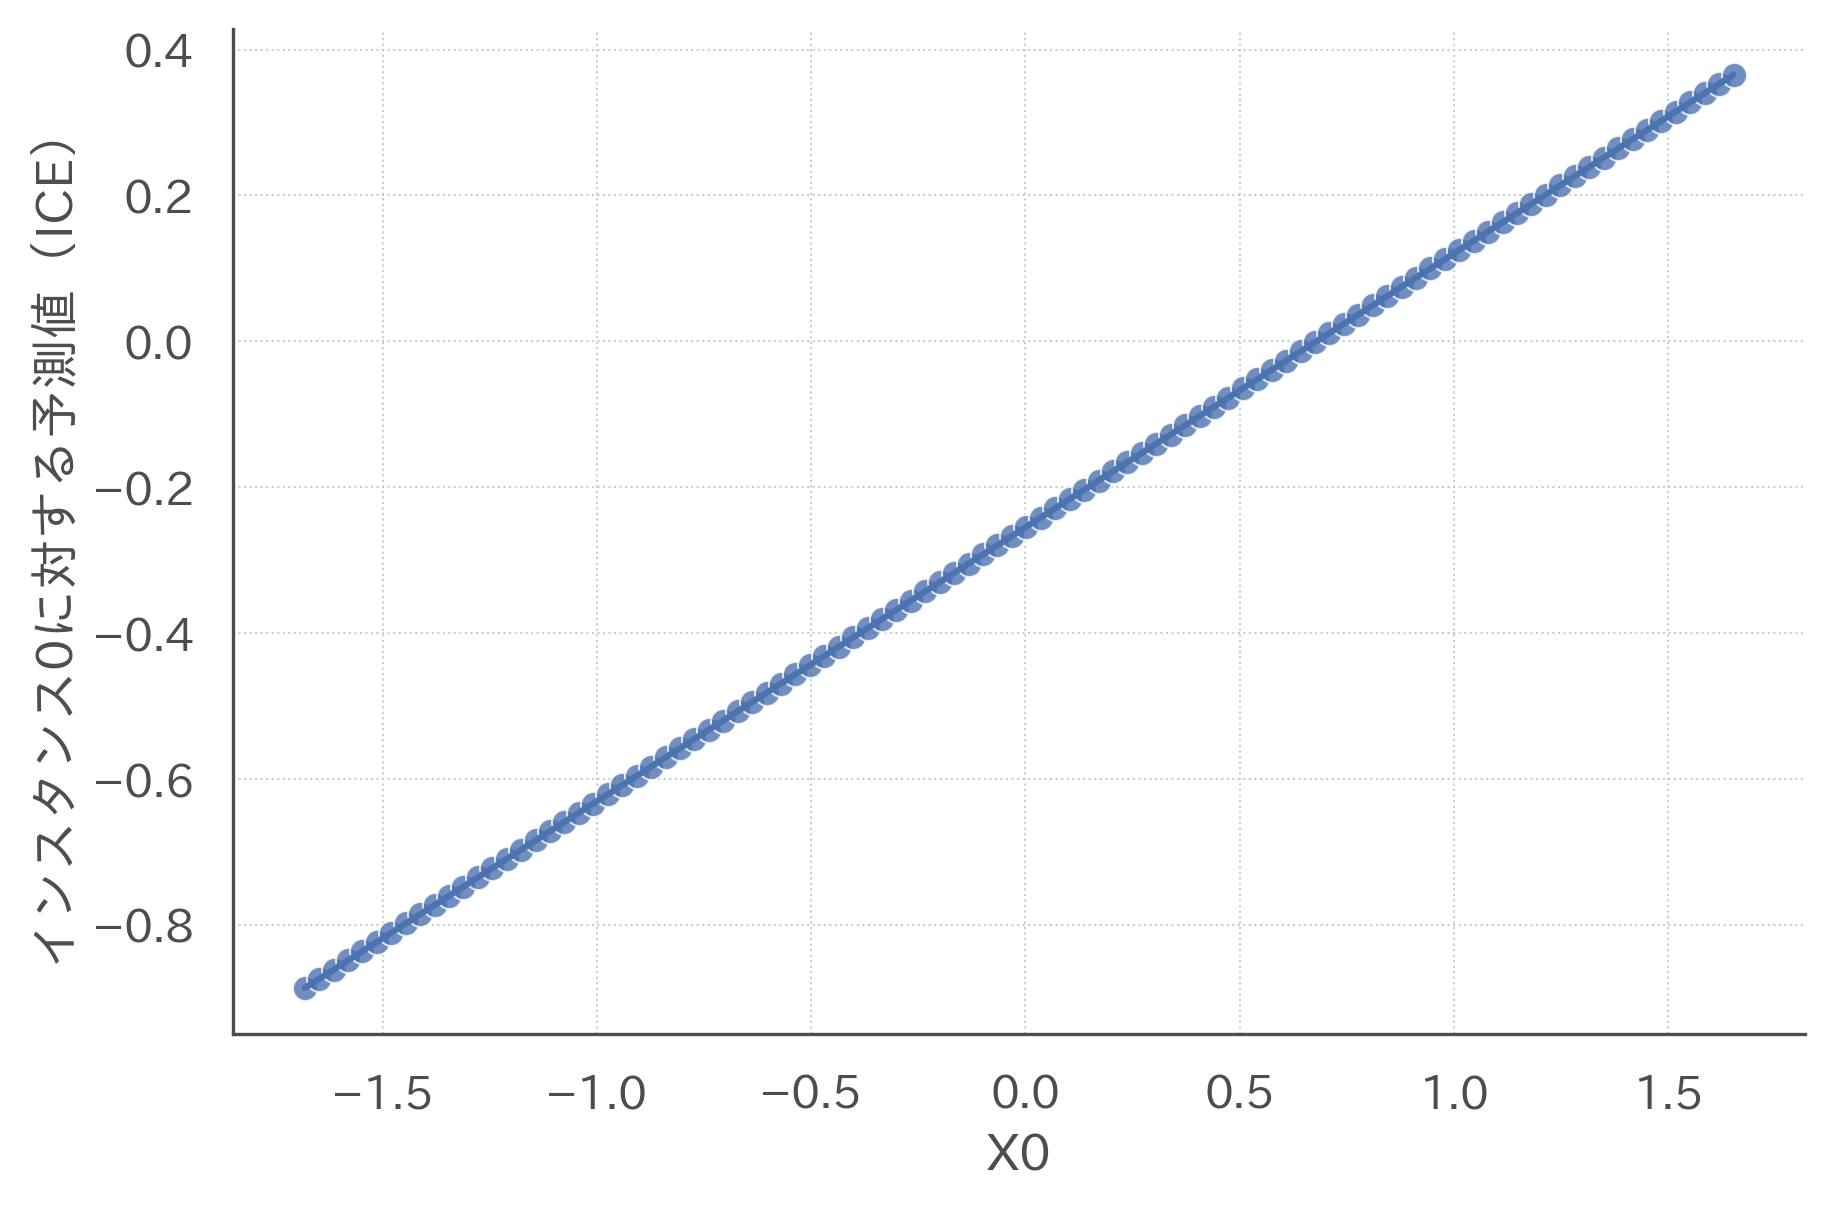

In [14]:
# ICEを可視化
plot_scatter(
    ice["values"][0], 
    ice["individual"][i][j], 
    intercept=intercept_ij, 
    slope=lm.coef_[j],
    xlabel=f"X{j}",
    ylabel=f"インスタンス{i}に対する予測値（ICE）"
)

In [15]:
# シミュレーションデータを小さく作り直す
X, y, beta = generate_simulation_data(N=10000, J=10)

# 線形回帰モデルの学習
lm = LinearRegression().fit(X, y)

In [16]:
import shap

i = 0  # インスタンスのインデックス

# SHAPを計算するためのexplainerを作成
explainer = shap.explainers.Exact(
    model=lm.predict,
    masker=shap.maskers.Independent(data=X, max_samples=10000)
)

# インスタンス0に対してSHAPを計算
shap_values = explainer(X[[0], :])

In [17]:
# 線形回帰モデルの貢献度を計算
phi_ij = ((X - X.mean(axis=0)) * lm.coef_)

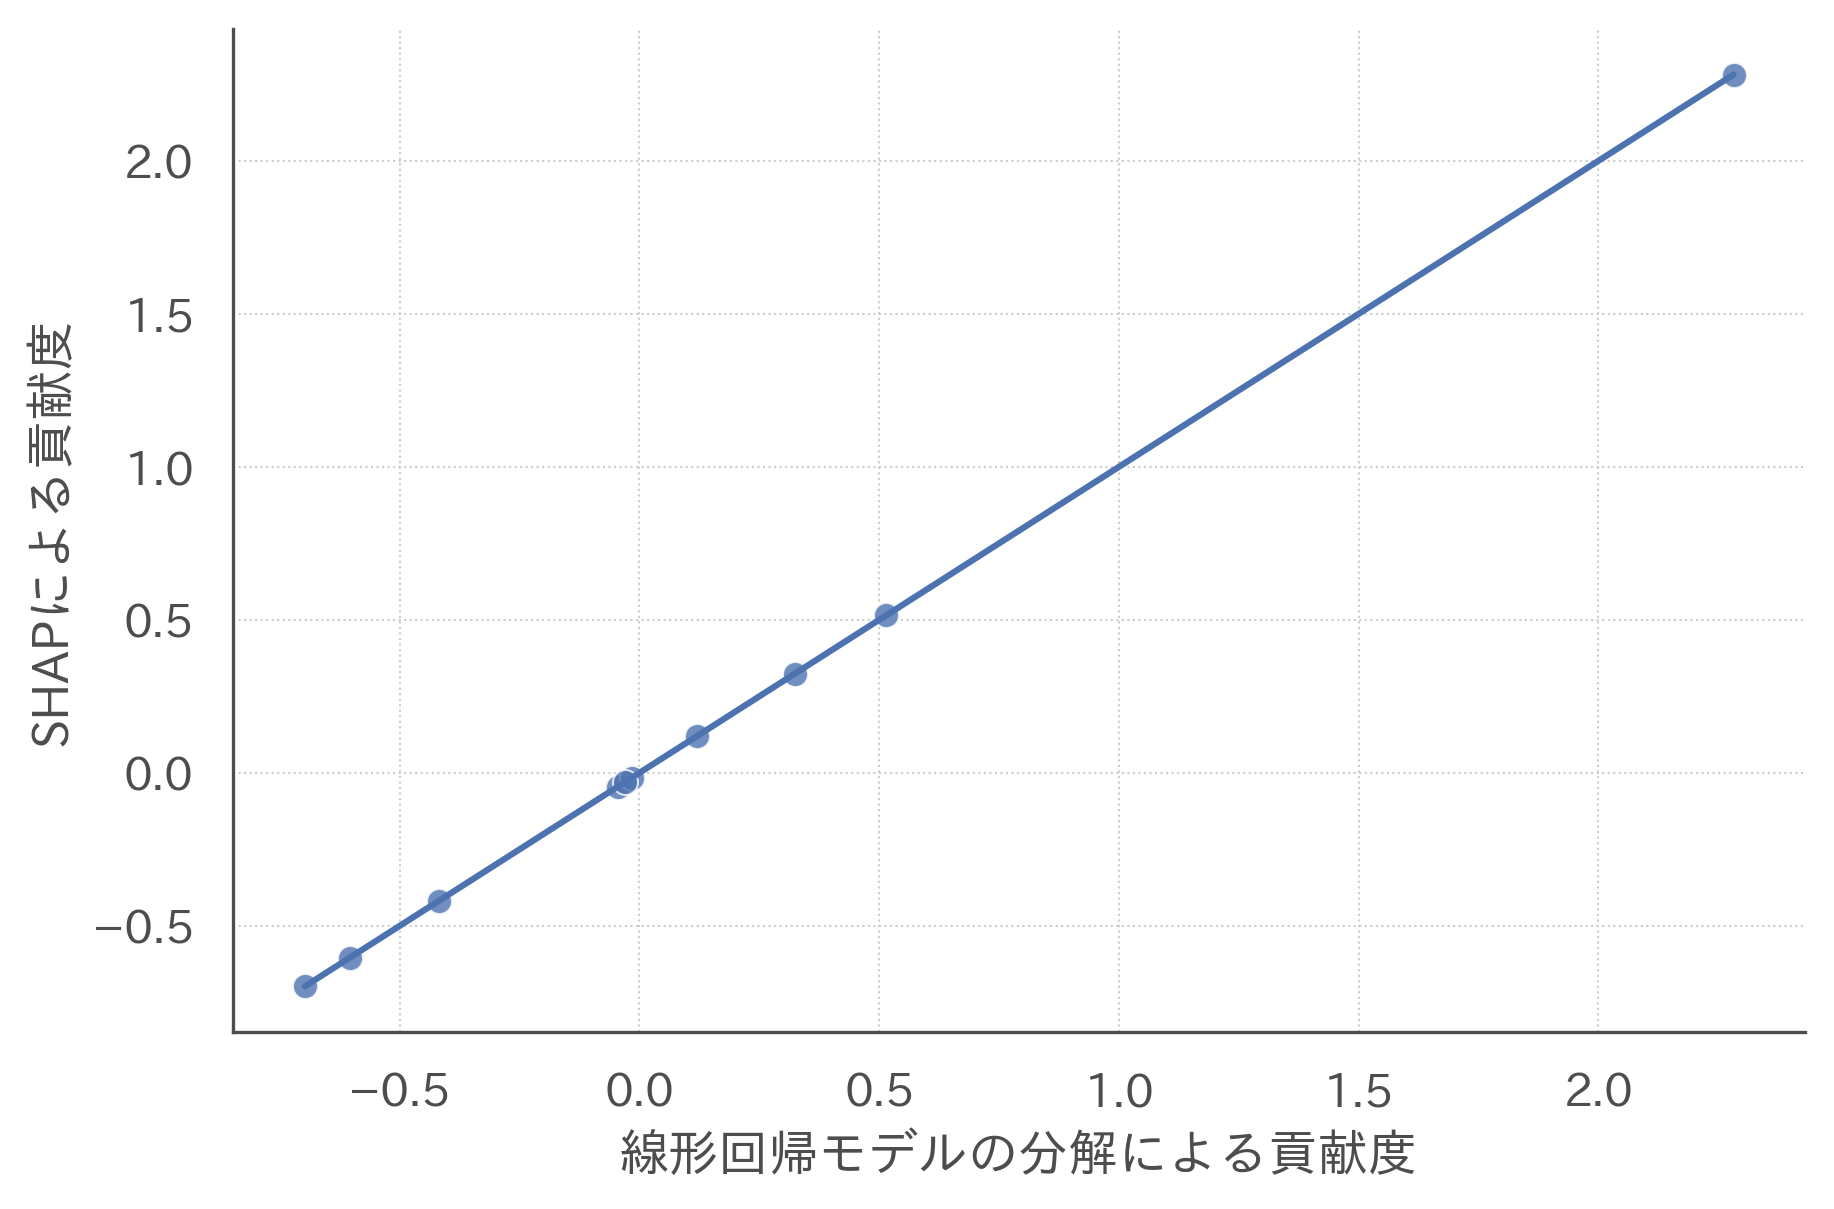

In [18]:
#　可視化
plot_scatter(
    phi_ij[i], 
    shap_values.values[i],
    xlabel="線形回帰モデルの分解による貢献度",
    ylabel="SHAPによる貢献度"
)